#### 訓練資料
在 https://www.dropbox.com/scl/fi/jv072cyo3y62f6ykw54l8/dataset1.zip?rlkey=mf1tmtrnd6ys7m7oi4ygtcro9&st=vj8bwlik&dl=1

覺得很麻煩就不用程式下載了，自己去抓就好

In [2]:
import torch
import os, cv2, random, glob
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms, models, datasets
from torchvision.ops import nms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import warnings
import configparser
from random import randint
warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [4]:
# Load configuration
config = configparser.ConfigParser()
config.read('config.ini')
# Load parameters from config file
#root = '/Users/leonjye/Documents/MachineLearingData'
root = config.get('DEFAULT', 'root_dir')
IMAGE_ROOT = os.path.join(root, 'dataset1')

In [5]:
class SegData(Dataset):
    def __init__(self, image_dir=IMAGE_ROOT, split='train'):
        self.w = 224
        self.h = 224
        self.image_dir = os.path.join(image_dir, f'images_prepped_{split}')
        self.mask_dir = os.path.join(image_dir, f'annotations_prepped_{split}')
        self.items = [os.path.splitext(os.path.basename(x))[0] for x in glob.glob(f'{self.image_dir}/*.png')]
        #self.items = self.stems(f'dataset1/images_prepped_{split}')
        self.split = split
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        img_path = f'{self.image_dir}/{self.items[ix]}.png'
        image = Image.open(img_path).convert("RGB")
        image = np.array(image.resize((self.w, self.h), resample=Image.BILINEAR))
        mask_path = f'{self.mask_dir}/{self.items[ix]}.png'
        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask.resize((self.w, self.h), resample=Image.NEAREST))
        #mask = cv2.imread(f'{self.mask_dir}/{self.items[ix]}.png', cv2.IMREAD_GRAYSCALE)
        #mask = cv2.resize(mask, (224,224))
        return image, mask
    
    def choose(self): return self[random.randint(0, len(self))-1]

    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([transform(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [6]:
trn_ds = SegData(image_dir=IMAGE_ROOT, split='train')
val_ds = SegData(image_dir=IMAGE_ROOT, split='test')
trn_dl = DataLoader(trn_ds, batch_size=16, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=6, shuffle=True, collate_fn=val_ds.collate_fn)

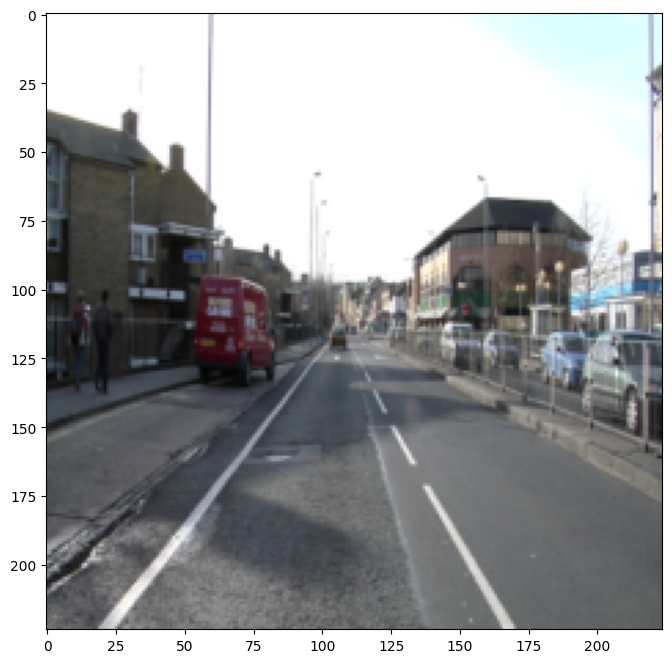

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.imshow(trn_ds.choose()[0])

In [7]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [8]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [9]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [15]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [16]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [17]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 5

In [18]:
for epoch in range(n_epochs):
    _n = len(trn_dl)
    for ix, inputs in enumerate(trn_dl):
        loss, acc = train_batch(model, inputs, optimizer, criterion)
        print(f"Epoch {epoch+1}/{n_epochs}, Batch {ix+1}/{_n}, Loss: {loss}, acc: {acc}")
    _n = len(val_dl)
    for ix,inputs in enumerate(val_dl):
        loss, acc  = validate_batch(model, inputs, criterion)
        print(f"Epoch {epoch+1}/{n_epochs}, Batch {ix+1}/{_n}, Loss: {loss}, acc: {acc}")
    
torch.save(model.state_dict(), '09_1_UNet_ImageSeq.pth')

Epoch 1/5, Batch 1/23, Loss: 2.4585909843444824, acc: 0.1553095579147339
Epoch 1/5, Batch 2/23, Loss: 2.184727668762207, acc: 0.43994140625
Epoch 1/5, Batch 3/23, Loss: 1.9813456535339355, acc: 0.5018771290779114
Epoch 1/5, Batch 4/23, Loss: 1.8519339561462402, acc: 0.5436500906944275
Epoch 1/5, Batch 5/23, Loss: 1.7321809530258179, acc: 0.5930262804031372
Epoch 1/5, Batch 6/23, Loss: 1.623885154724121, acc: 0.6671528816223145
Epoch 1/5, Batch 7/23, Loss: 1.528626561164856, acc: 0.7133464813232422
Epoch 1/5, Batch 8/23, Loss: 1.5073274374008179, acc: 0.7104616761207581
Epoch 1/5, Batch 9/23, Loss: 1.4330495595932007, acc: 0.7519307136535645
Epoch 1/5, Batch 10/23, Loss: 1.4169613122940063, acc: 0.7284085154533386
Epoch 1/5, Batch 11/23, Loss: 1.3613433837890625, acc: 0.7596011757850647
Epoch 1/5, Batch 12/23, Loss: 1.2851471900939941, acc: 0.7906182408332825
Epoch 1/5, Batch 13/23, Loss: 1.3063671588897705, acc: 0.7688710689544678
Epoch 1/5, Batch 14/23, Loss: 1.2564889192581177, acc: 

In [10]:
# Load the pre-trained model weights
model = UNet().to(device)
model.load_state_dict(torch.load('09_1_UNet_ImageSeq.pth'))
model.eval()
print('Model loaded successfully.')

Model loaded successfully.


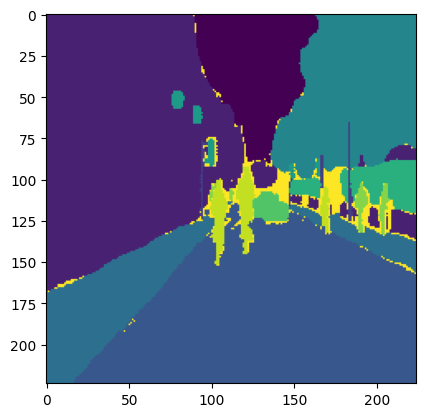

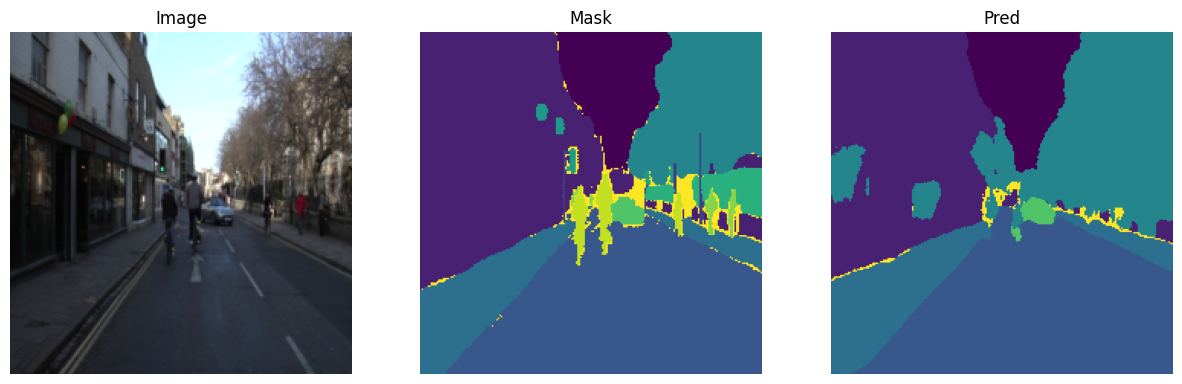

In [ ]:
image_val, mask_val = val_ds.choose()
_image = transform(image_val.copy()/255.).unsqueeze(0).float().to(device)
model.eval()
with torch.no_grad():
    _mask = model(_image)
    _mask = torch.argmax(_mask, dim=1).squeeze().cpu().numpy()
    
image_outs = [image_val, mask_val, _mask]
fig, ax = plt.subplots(1,3, figsize=(15,15))
for i in range(3):
    ax[i].imshow(image_outs[i])
    ax[i].set_title(['Image', 'Mask', 'Pred'][i])
    ax[i].axis('off')
plt.show()
fig.savefig('09_1_UNet_ImageSeq.png', dpi=300, bbox_inches='tight')

In [ ]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)

image_outs = [
    im[0].permute(1,2,0).detach().cpu()[:,:,0], 
    mask.permute(1,2,0).detach().cpu()[:,:,0],
    _mask.permute(1,2,0).detach().cpu()[:,:,0]]

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

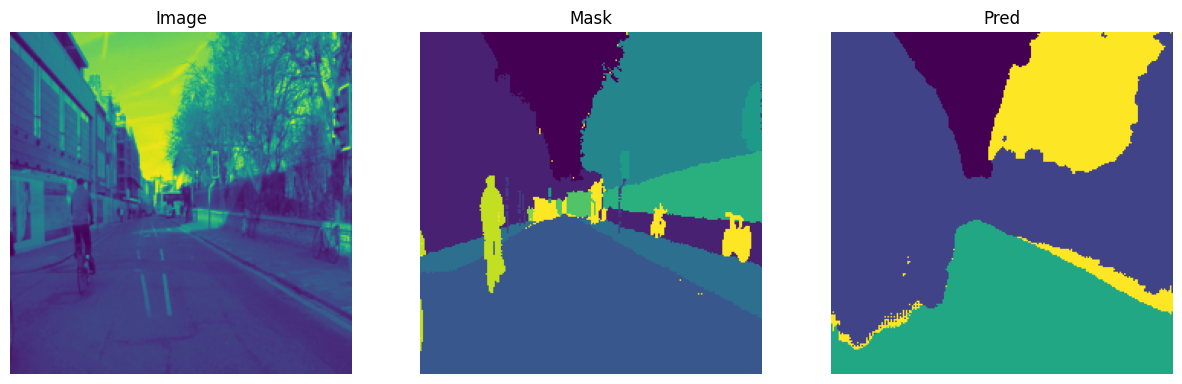

In [16]:
fig, ax = plt.subplots(1,3, figsize=(15,15))
for i in range(3):
    ax[i].imshow(image_outs[i])
    ax[i].set_title(['Image', 'Mask', 'Pred'][i])
    ax[i].axis('off')
plt.show()
fig.savefig('09_1_UNet_ImageSeq.png', dpi=300, bbox_inches='tight')